# Comparison of Full vs Profile Likelihood Methods



### How to run the code

#### On local machine

Run `/benchmark/scripts/benchmark_speed.py`.

The output is stored in `/benchnmark/pickle_results/benchmark_results.pickle`. 


#### Run on cluster

To run this script on a cluster with Torque:

    cd jobfiles
    qsub jobfile_benchmark_speed.pbs

In [1]:
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
benchmark_dir = '..'
# base_filename = 'benchmark_speed_dense'
base_filename = 'benchmark_speed'
#base_filename = 'benchmark_speed_sparse_cg'
#base_filename = 'benchmark_speed_sparse_ncg'
results_filename = join(benchmark_dir, 'pickle_results', base_filename + '.pickle')

with open(results_filename, 'rb') as file:
    benchmark_result = pickle.load(file)
    
print('Config:')
pp.pprint(benchmark_result['config'])
print('')
print('Devices:')
pp.pprint(benchmark_result['devices'])
print('')
results = benchmark_result['results']
num_data = len(results)
print('num data: %d' % num_data)
print('')
date = benchmark_result['date']
print('date: %s' % date)

# Extract variables
data_sizes = benchmark_result['config']['data_sizes']

opt_proc_time = {}
opt_proc_time['full'] = numpy.zeros((num_data), dtype=float)
opt_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

opt_wall_time = {}
opt_wall_time['full'] = numpy.zeros((num_data), dtype=float)
opt_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

cor_proc_time = {}
cor_proc_time['full'] = numpy.zeros((num_data), dtype=float)
cor_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

cor_wall_time = {}
cor_wall_time['full'] = numpy.zeros((num_data), dtype=float)
cor_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

det_proc_time = {}
det_proc_time['full'] = numpy.zeros((num_data), dtype=float)
det_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

det_wall_time = {}
det_wall_time['full'] = numpy.zeros((num_data), dtype=float)
det_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

trc_proc_time = {}
trc_proc_time['full'] = numpy.zeros((num_data), dtype=float)
trc_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

trc_wall_time = {}
trc_wall_time['full'] = numpy.zeros((num_data), dtype=float)
trc_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

sol_proc_time = {}
sol_proc_time['full'] = numpy.zeros((num_data), dtype=float)
sol_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

sol_wall_time = {}
sol_wall_time['full'] = numpy.zeros((num_data), dtype=float)
sol_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

lik_proc_time = {}
lik_proc_time['full'] = numpy.zeros((num_data), dtype=float)
lik_proc_time['prof'] = numpy.zeros((num_data), dtype=float)

lik_wall_time = {}
lik_wall_time['full'] = numpy.zeros((num_data), dtype=float)
lik_wall_time['prof'] = numpy.zeros((num_data), dtype=float)

sigma = {}
sigma['full'] = numpy.zeros((num_data), dtype=float)
sigma['prof'] = numpy.zeros((num_data), dtype=float)

sigma0 = {}
sigma0['full'] = numpy.zeros((num_data), dtype=float)
sigma0['prof'] = numpy.zeros((num_data), dtype=float)

eta = {}
eta['full'] = numpy.zeros((num_data), dtype=float)
eta['prof'] = numpy.zeros((num_data), dtype=float)

num_opt_iter = {}
num_opt_iter['full'] = numpy.zeros((num_data), dtype=float)
num_opt_iter['prof'] = numpy.zeros((num_data), dtype=float)

num_fun_eval = {}
num_fun_eval['full'] = numpy.zeros((num_data), dtype=float)
num_fun_eval['prof'] = numpy.zeros((num_data), dtype=float)

num_jac_eval = {}
num_jac_eval['full'] = numpy.zeros((num_data), dtype=float)
num_jac_eval['prof'] = numpy.zeros((num_data), dtype=float)

num_hes_eval = {}
num_hes_eval['full'] = numpy.zeros((num_data), dtype=float)
num_hes_eval['prof'] = numpy.zeros((num_data), dtype=float)

max_fun = {}
max_fun['full'] = numpy.zeros((num_data), dtype=float)
max_fun['prof'] = numpy.zeros((num_data), dtype=float)
max_fun_rel = numpy.zeros((num_data), dtype=float)

success = {}
success['full'] = numpy.zeros((num_data), dtype=float)
success['prof'] = numpy.zeros((num_data), dtype=float)

for i in range(num_data):
    opt_proc_time['full'][i] = results[i]['full_likelihood']['time']['opt_proc_time']
    opt_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['opt_proc_time']
    opt_wall_time['full'][i] = results[i]['full_likelihood']['time']['opt_wall_time']
    opt_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['opt_wall_time']
    
    cor_proc_time['full'][i] = results[i]['full_likelihood']['time']['cor_proc_time']
    cor_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['cor_proc_time']
    cor_wall_time['full'][i] = results[i]['full_likelihood']['time']['cor_wall_time']
    cor_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['cor_wall_time']
    
    det_proc_time['full'][i] = results[i]['full_likelihood']['time']['det_proc_time']
    det_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['det_proc_time']
    det_wall_time['full'][i] = results[i]['full_likelihood']['time']['det_wall_time']
    det_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['det_wall_time']
    
    trc_proc_time['full'][i] = results[i]['full_likelihood']['time']['trc_proc_time']
    trc_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['trc_proc_time']
    trc_wall_time['full'][i] = results[i]['full_likelihood']['time']['trc_wall_time']
    trc_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['trc_wall_time']
    
    sol_proc_time['full'][i] = results[i]['full_likelihood']['time']['sol_proc_time']
    sol_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['sol_proc_time']
    sol_wall_time['full'][i] = results[i]['full_likelihood']['time']['sol_wall_time']
    sol_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['sol_wall_time']
    
    lik_proc_time['full'][i] = results[i]['full_likelihood']['time']['lik_proc_time']
    lik_proc_time['prof'][i] = results[i]['prof_likelihood']['time']['lik_proc_time']
    lik_wall_time['full'][i] = results[i]['full_likelihood']['time']['lik_wall_time']
    lik_wall_time['prof'][i] = results[i]['prof_likelihood']['time']['lik_wall_time']
    
    sigma['full'][i] = results[i]['full_likelihood']['hyperparam']['sigma']
    sigma['prof'][i] = results[i]['prof_likelihood']['hyperparam']['sigma']
    sigma0['full'][i] = results[i]['full_likelihood']['hyperparam']['sigma0']
    sigma0['prof'][i] = results[i]['prof_likelihood']['hyperparam']['sigma0']
    eta['full'][i] = results[i]['full_likelihood']['hyperparam']['eta']
    eta['prof'][i] = results[i]['prof_likelihood']['hyperparam']['eta']
    
    num_opt_iter['full'][i] = results[i]['full_likelihood']['optimization']['num_opt_iter']
    num_opt_iter['prof'][i] = results[i]['prof_likelihood']['optimization']['num_opt_iter']
    num_fun_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_fun_eval']
    num_fun_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_fun_eval']
    num_jac_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_jac_eval']
    num_jac_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_jac_eval']
    num_hes_eval['full'][i] = results[i]['full_likelihood']['optimization']['num_hes_eval']
    num_hes_eval['prof'][i] = results[i]['prof_likelihood']['optimization']['num_hes_eval']
    max_fun['full'][i] = results[i]['full_likelihood']['optimization']['max_fun']
    
    max_fun_prof = results[i]['prof_likelihood']['optimization']['max_fun']
    if isinstance(max_fun_prof, float):
        max_fun['prof'][i] = max_fun_prof
        max_fun_rel[i] = 1.0 - max_fun['prof'][i] / max_fun['full'][i]
    else:
        max_fun['prof'][i] = numpy.nan
        max_fun_rel[i] = numpy.nan
    #success['full'][i] = results[i]['full_likelihood']['optimization']['success']
    #success['prof'][i] = results[i]['prof_likelihood']['optimization']['success']

Config:
{   'B': None,
    'b': None,
    'data_sizes': array([ 16,  32,  64, 128]),
    'dimension': 2,
    'grid': True,
    'hyperbolic_coeff': None,
    'hyperparam_guesses': {'none': [0.1, 0.1], 'var': None},
    'imate_options': {   'lanczos_degree': 70,
                         'max_num_samples': 500,
                         'method': 'slq',
                         'min_num_samples': 100},
    'kernel': 'Exponential',
    'kernel_threshold': 0.03,
    'noise_magnitude': 0.2,
    'optimization_method': {'none': 'CG', 'var': 'CG'},
    'polynomial_degree': 2,
    'profile_hyperparam': ['var', 'none'],
    'scale': 0.003,
    'sparse': True,
    'trigonometric_coeff': None,
    'verbose': False}

Devices:
{   'cuda_version': 'not found',
    'glearn_version': '0.15.2',
    'gpu_name': 'none',
    'imate_version': '0.10.4',
    'mem_unit': 'Mb',
    'mem_used': 63.0703125,
    'num_cpu_threads': 20,
    'num_gpu_devices': 0,
    'processor_name': 'Intel(R) Xeon(R) CPU E5-2680 v2 @

In [3]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]

In [10]:
# Plot Variables
plot_wall_time = False
full_color = '#0093FF'
prof_color = '#77B900'

# ========
# plot var
# ========

def plot_var(ax_, var, ylabel, title, ylog=False):

    if isinstance(var, dict):
        ax_.plot(data_sizes, var['full'], '-o', color=full_color, label='full')
        ax_.plot(data_sizes, var['prof'], '-s', color=prof_color, label='profiled')
        
        handles,labels = ax_.get_legend_handles_labels()
        ax_.legend(handles, labels, fontsize='x-small')
    else:
        ax_.plot(data_sizes, var, '-o', color=full_color)

    ax_.set_xscale('log', base=2)
    if ylog:
        ax_.set_yscale('log', base=10)

    ax_.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax_.set_xticks(data_sizes)

    ax_.set_ylabel(ylabel)
    ax_.set_title(title)

    ax_.set_xlabel(r'$n$')
    ax_.grid(axis='y', which='major')
    
# =========
# save plot
# =========

def save_plot(plt, name):
    
    plt.tight_layout()
    save_dir = 'svg_plots'
    filename_svg = name + '.svg'
    plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=True, bbox_inches='tight')
    print('Plot saved to "%s".' % (filename_svg))

Plot saved to "benchmark_speed_proc_time.svg".


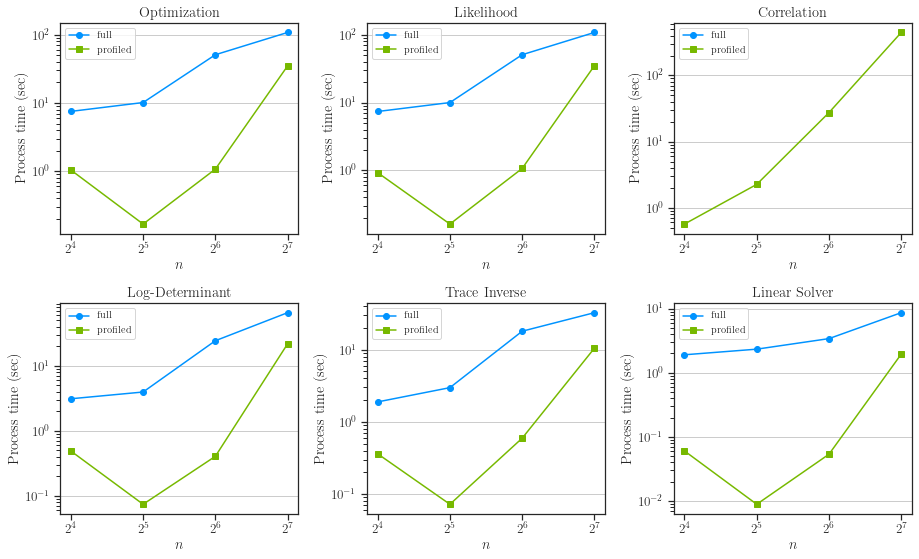

In [11]:
fig, ax = plt.subplots(figsize=(13, 8), nrows=2, ncols=3)

# Plot time
plot_var(ax[0, 0], opt_proc_time, 'Process time (sec)', 'Optimization', ylog=True)
plot_var(ax[0, 1], lik_proc_time, 'Process time (sec)', 'Likelihood', ylog=True)
plot_var(ax[0, 2], cor_proc_time, 'Process time (sec)', 'Correlation', ylog=True)
plot_var(ax[1, 0], det_proc_time, 'Process time (sec)', 'Log-Determinant', ylog=True)
plot_var(ax[1, 1], trc_proc_time, 'Process time (sec)', 'Trace Inverse', ylog=True)
plot_var(ax[1, 2], sol_proc_time, 'Process time (sec)', 'Linear Solver', ylog=True)

# Save plot
save_plot(plt, 'benchmark_speed_proc_time')

Plot saved to "benchmark_speed_wall_time.svg".


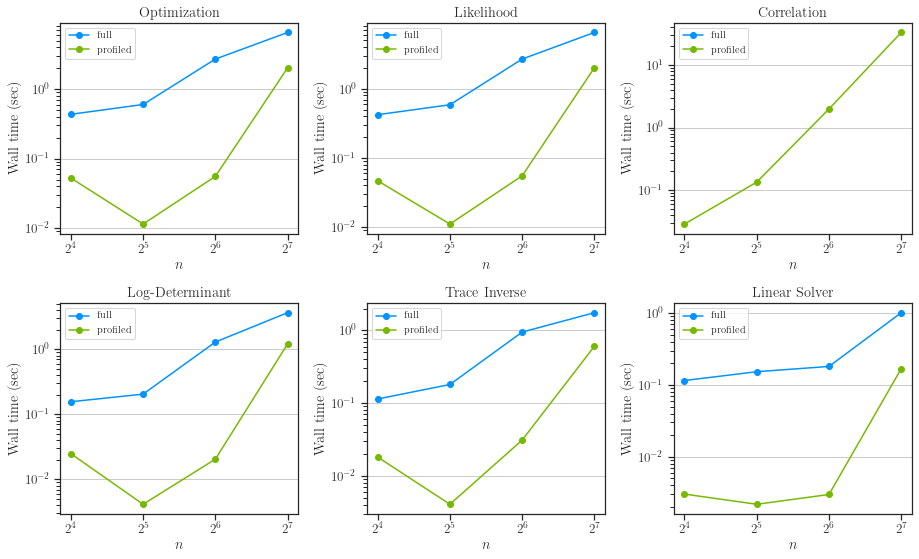

In [6]:
fig, ax = plt.subplots(figsize=(13, 8), nrows=2, ncols=3)

# Plot time
plot_var(ax[0, 0], opt_wall_time, 'Wall time (sec)', 'Optimization', ylog=True)
plot_var(ax[0, 1], lik_wall_time, 'Wall time (sec)', 'Likelihood', ylog=True)
plot_var(ax[0, 2], cor_wall_time, 'Wall time (sec)', 'Correlation', ylog=True)
plot_var(ax[1, 0], det_wall_time, 'Wall time (sec)', 'Log-Determinant', ylog=True)
plot_var(ax[1, 1], trc_wall_time, 'Wall time (sec)', 'Trace Inverse', ylog=True)
plot_var(ax[1, 2], sol_wall_time, 'Wall time (sec)', 'Linear Solver', ylog=True)

# Save plot
save_plot(plt, 'benchmark_speed_wall_time')

Plot saved to "benchmark_speed_hyperparam.svg".


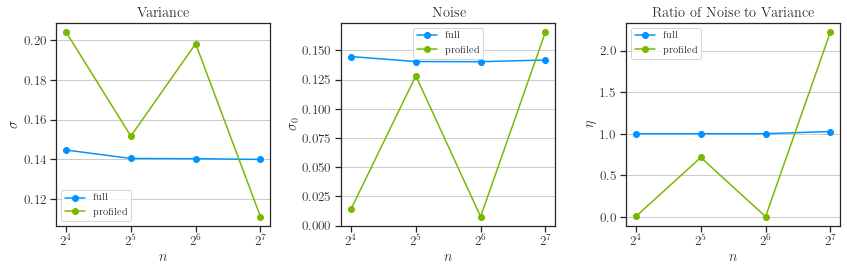

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

# Plot sigmas
plot_var(ax[0], sigma, r'$\sigma$', 'Variance')
plot_var(ax[1], sigma0, r'$\sigma_0$', 'Noise')
plot_var(ax[2], eta, r'$\eta$', 'Ratio of Noise to Variance')

# Save plot
save_plot(plt, 'benchmark_speed_hyperparam')

Plot saved to "benchmark_speed_iter.svg".


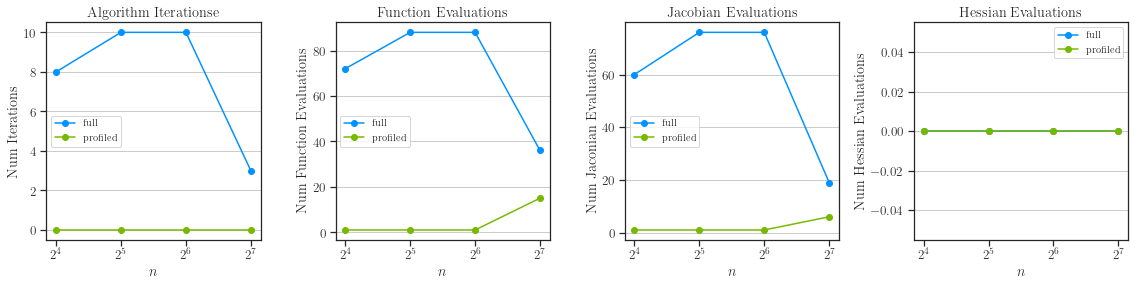

In [8]:
fig, ax = plt.subplots(figsize=(16, 4.2), nrows=1, ncols=4)

# Plot iterations
plot_var(ax[0], num_opt_iter, 'Num Iterations', 'Algorithm Iterationse')
plot_var(ax[1], num_fun_eval, 'Num Function Evaluations', 'Function Evaluations')
plot_var(ax[2], num_jac_eval, 'Num Jaconian Evaluations', 'Jacobian Evaluations')
plot_var(ax[3], num_hes_eval, 'Num Hessian Evaluations', 'Hessian Evaluations')

# Save plot
save_plot(plt, 'benchmark_speed_iter')

Plot saved to "benchmark_speed_posterior.svg".


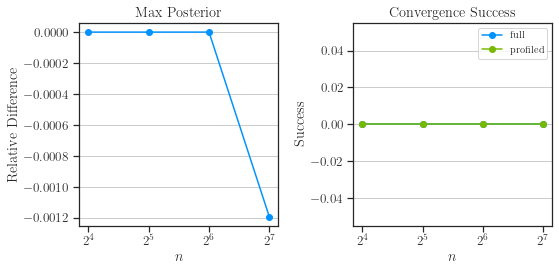

In [9]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2)

# Plot iterations
plot_var(ax[0], max_fun_rel, 'Relative Difference', 'Max Posterior')
plot_var(ax[1], success, 'Success', 'Convergence Success')

# Save plot
save_plot(plt, 'benchmark_speed_posterior')